
---


**Projet Dapyness - Estimation de ventes e-commerce** 


---

*L’objectif de ce projet est d’estimer l’évolution du volume de vente de produits vendus en ligne par un site e-commerce en utilisant les données de ces ventes.*

*Pour cela, nous étudions une table de données que nous nommons **df** lors de l'importation.*



*   Nous commençons notre étude par importer, analyser et nettoyer notre jeu de données. 
*   Ensuite, nous créons de nouvelles variables jugées utiles pour la suite de notre étude.
*   Nous analysons ensuite graphiquement nos données.
*   Et enfin, nous procédons à la modélisation de nos données pour espérer obtenir de bonnes prévisions de ventes.






L'ensemble des fichiers codes de ce projet sont décomposés en 5 parties :



*   01 - Analyse exploratoire 1/2 - Etude des différentes colonnes
*   02 - Analyse exploratoire 2/2 - Etude des valeurs manquantes
*   03 - Création de nouvelles colonnes
*   04 - Etude graphique des variables et tests statistiques
*   **05 - Modélisation - Time Series**

# **Préparation du Dataset et premières informations**

In [ ]:
# Cellule d'imporation des packages nécessaires aux codes

#packages basiques
import pandas as pd
import numpy as np

#partie graphique
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from bokeh.plotting import figure, output_notebook, show
output_notebook()

#tests statistiques
import statsmodels.api 
from scipy.stats import pearsonr

#modélisation
#régression
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

#modèles arima et sarima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [ ]:
#Importation du fichier csv  
df=pd.read_csv('data-estimation.csv', sep=';')

In [ ]:
#Remplacement des valeurs manquantes NaN de CustomerID par une catégorie "Client non identifié"
df['CustomerID'].fillna('Client non identifié', inplace =True)

In [ ]:
#Suppression des lignes contenant une valeur manquante NaN dans la variable Description 
df= df.dropna(axis=0,how='any', subset=['Description'])

In [ ]:
#creation d'une nouvelle colonne TotalAmount 
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
#Conversion de la colonne InvoiceDate en to_datetime (car initialement de type object)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
#colonne correspondant à la date (sans la partie timing)
df['Date'] = pd.to_datetime(df.InvoiceDate).dt.date
#année, mois et jour de mois et de la semaine
df['Year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['Month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['Day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['DayOfWeek'] = pd.to_datetime(df.InvoiceDate).dt.weekday
df['DayName'] = df.InvoiceDate.dt.day_name()
#numéro de la semaine de l'année
df['Week']=df.InvoiceDate.dt.week
#création d'une colonne heure car time est trop précis
df['Hour'] = pd.to_datetime(df.InvoiceDate).dt.hour

In [ ]:
# 0) création de la nouvelle colonne InvoiceType avec valeur par défaut 'abcd'
df['InvoiceType']='abcd'

# 1) 
#Catégorisation des dettes dans notre nouvelle colonne InvoiceType
df[df['InvoiceNo'].str.contains("A")]=df[df['InvoiceNo'].str.contains("A")].replace(to_replace=['abcd'],value=['Debt'])
#Catégorisation des annulations de commandes (retours) dans notre nouvelle colonne InvoiceType
df[df['InvoiceNo'].str.contains("C")]=df[df['InvoiceNo'].str.contains("C")].replace(to_replace=['abcd'],value=['Canceled'])
#Catégorisation des autres lignes en ventes 'Sale'
#Pour cela, on extrait les lignes pour lesquels InvoiceNo ne contient pas 'A' ou 'C'
df[-((df['InvoiceNo'].str.contains("A"))&(df['InvoiceNo'].str.contains("C")))]=df[-((df['InvoiceNo'].str.contains("A"))&(df['InvoiceNo'].str.contains("C")))].replace(to_replace=['abcd'],value=['Sale'])

# 2) Modification des catégories 'Canceled' et 'Sale' en fonction du stockCode et ce à quoi ça correspond
# catégorie Discount
df[df['StockCode']=='D']=df[df['StockCode']=='D'].replace(to_replace=['Canceled','Sale'],value=['Discount','Discount'])
# catégorie Amazon fee
df[df['StockCode']=='AMAZONFEE']=df[df['StockCode']=='AMAZONFEE'].replace(to_replace=['Canceled','Sale'],value=['Amazon fee','Amazon fee'])
# catégorie Commission
df[df['StockCode']=='CRUK']=df[df['StockCode']=='CRUK'].replace(to_replace=['Canceled','Sale'],value=['Commission','Commission'])
# catégorie Sample 
df[df['StockCode']=='S']=df[df['StockCode']=='S'].replace(to_replace=['Canceled','Sale'],value=['Sample','Sample'])
# catégorie Manual order
df[df['StockCode']=='M']=df[df['StockCode']=='M'].replace(to_replace=['Sale','Canceled'],value = ['Manual order','Manual order'])
# catégorie Postage
df[(df['StockCode']=='POST')|(df['StockCode']=='DOT')]=df[(df['StockCode']=='DOT')|(df['StockCode']=='POST')].replace(to_replace=['Sale','Canceled'],value=['Postage','Postage'])
# catégorie Carriage
df[df['StockCode']=='C2']=df[df['StockCode']=='C2'].replace(to_replace=['Sale','Canceled'],value=['Carriage','Carriage'])
# catégorie Bank charges
df[df['StockCode']=='BANK CHARGES']=df[df['StockCode']=='BANK CHARGES'].replace(to_replace=['Sale','Canceled'],value=['Bank charges','Bank charges'])



In [ ]:
# 3) On veut maintenant catégoriser les lignes pour lesquels on a des description qui semblent correspondre à des problèmes
# on crée d'abord une liste contenant les descriptions 'problèmes'
Description_problems = ['amazon', '?', 'check', 'damages','faulty', 'Dotcom sales', 'amazon sales', 'Found',
       'reverse 21/5/10 adjustment','mouldy, thrown away.', 'found', 'counted', 'Given away', 'Dotcom', 'label mix up',
       'samples/damages', 'thrown away', 'incorrectly made-thrown away.','showroom', 'MIA', 'Adjustment',
       'Dotcom set', 'wrongly sold as sets', 'Amazon sold sets','dotcom sold sets', 'wrongly sold sets', 
       '? sold as sets?','?sold as sets?', 'Thrown away.', 'damages/display','damaged stock', 'broken', 'throw away',
       'wrong barcode (22467)', 'wrongly sold (22719) barcode','wrong barcode', 'barcode problem', '?lost',
       "thrown away-can't sell.", "thrown away-can't sell",'rcvd be air temp fix for dotcom sit', 'damages?',
       're dotcom quick fix.', "Dotcom sold in 6's", 'sold in set?','cracked', 'sold as 22467', 'Damaged',
       'mystery! Only ever imported 1800','MERCHANT CHANDLER CREDIT ERROR, STO', 'POSSIBLE DAMAGES OR LOST?',
       'damaged', 'DAMAGED', 'did  a credit  and did not tick ret','Display', 'Missing', 'adjustment', 'returned', 'wrong code?',
       'wrong code', 'adjust', 'crushed', 'damages/showroom etc','samples', 'damages/credits from ASOS.', 'mailout ', 'mailout',
       'Not rcvd in 10/11/2010 delivery', 'Thrown away-rusty','sold as set/6 by dotcom', 'wet/rusty', 'damages/dotcom?',
       'on cargo order', 'smashed','incorrectly credited C550456 see 47','reverse previous adjustment', 'wet damaged',
       'Water damaged','missing', 'sold as set on dotcom','sold as set on dotcom and amazon', 'water damage',
       'sold as set by dotcom', 'Printing smudges/thrown away','printing smudges/thrown away',
       'to push order througha s stock was ', 'found some more on shelf','Show Samples', 'FOUND', 'mix up with c',
       'mouldy, unsaleable.', 'wrongly marked. 23343 in box', 'came coded as 20713',
       'alan hodge cant mamage this section','dotcom', 'FBA','stock creditted wrongly', 'ebay',
       'incorrectly put back into stock', 'Damages/samples','Sold as 1 on dotcom', 'taig adjust no stock', 
       'code mix up? 84930', '?display?', 'sold as 1', '?missing','crushed ctn', 'Crushed', 'test', 'temp adjustment',
       'taig adjust','allocate stock for dotcom orders ta', '??','add stock to allocate online orders', 
       'for online retail orders','Amazon', 'found box', 'OOPS ! adjustment', 'Found in w/hse',
       'website fixed', 'Dagamed', 'historic computer difference?....se','Lighthouse Trading zero invc incorr',
       'Incorrect stock entry.','incorrect stock entry.', 'michel oops', 'wrongly coded 20713',
       'wrongly coded-23343', 'stock check', 'crushed boxes','WET/MOULDY', "can't find", 'mouldy',
       'Wet pallet-thrown away','Had been put aside.', 'Sale error', 'Amazon Adjustment',
       'wrongly marked 23343', '20713 wrongly marked', 're-adjustment','Breakages', 'Marked as 23343', '20713', 
       'wrongly coded 23343','Found by jackie', 'Damages', 'CHECK', 'Unsaleable, destroyed.',
       'wrongly marked', 'dotcom sales', 'had been put aside','damages wax', 'water damaged', 'Wrongly mrked had 85123a in box',
       'wrongly marked carton 22804', 'missing?', 'wet rusty','amazon adjust', '???lost', 'dotcomstock',
       'John Lewis','sold with wrong barcode', 'dotcom adjust', 'rusty thrown away','rusty throw away', 'check?',
       '?? missing', 'wet pallet','????missing', '???missing', 'AMAZON', 'lost in space', 'wet?',
       'lost??', '???', 'wet', 'wet boxes','????damages????', 'mixed up', 'lost']

In [ ]:
# catégorisation 'Order problem' lorsque la colonne Descirption comporte une valeur appartenant à la liste Description_problems
df[df.Description.isin(Description_problems)] = df[df.Description.isin(Description_problems)].replace(to_replace='Sale',value='Order problem')
# 4) catégorisation des lignes pour lesquelles on a un prix == 0 (hors Order problem)
df[df['UnitPrice']==0] = df[df['UnitPrice']==0].replace(to_replace='Sale', value='Gift')

In [ ]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
#Création d'un dataframe comprenant uniquement les ventes (InvoiceType = Sale)
df_sale = df[(df['InvoiceType']=='Sale')]

# **Modélisations - Time Series**

## *1) Preprocessing - Stationariser et déterminer les paramètres*


In [ ]:
#On repart de nos données quantity agrégées par jour
df_daily = df_sale.groupby(by=['Date'])['Quantity'].sum().reset_index()
df_daily.head()

,Date,Quantity
0,2010-12-01,26909
1,2010-12-02,31327
2,2010-12-03,16177
3,2010-12-05,16371
4,2010-12-06,21768


In [ ]:
#conversion de la date en format date
df_daily['Date'] = pd.to_datetime(df_daily['Date'])

In [ ]:
#on place la date en index
df_daily.index=df_daily.Date
df_daily=df_daily.drop(['Date'], axis=1)

In [ ]:
#on enregistre df_daily sous forme de série
df_daily = pd.Series(data=df_daily['Quantity'])
df_daily

Date
2010-12-01    26909
2010-12-02    31327
2010-12-03    16177
2010-12-05    16371
2010-12-06    21768
              ...  
2011-12-05    43755
2011-12-06    30437
2011-12-07    41857
2011-12-08    35066
2011-12-09    93968
Name: Quantity, Length: 305, dtype: int64

In [ ]:
#ou bien on fait 
#df_daily.to_csv('df_daily.csv')
#df_daily = pd.read_csv('', header=0, parse_dates=[0], index_col=0, squeeze=True)
#df_daily.head()

Date
2010-12-01    26909
2010-12-02    31327
2010-12-03    16177
2010-12-05    16371
2010-12-06    21768
Name: Quantity, dtype: int64

In [ ]:
#on vérifie que la série est bien indexées par les dates
print(df_daily.index)

DatetimeIndex(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-05',
               '2010-12-06', '2010-12-07', '2010-12-08', '2010-12-09',
               '2010-12-10', '2010-12-12',
               ...
               '2011-11-29', '2011-11-30', '2011-12-01', '2011-12-02',
               '2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07',
               '2011-12-08', '2011-12-09'],
              dtype='datetime64[ns]', name='Date', length=305, freq=None)


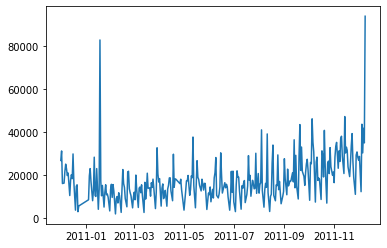

In [ ]:
#représentation graphique de la série temporelle
plt.plot(df_daily);

In [ ]:
''' tout d'abord, nous devons nous assurer que la série est stationaire. 
Dans le cas où cette condition n'est pas vérifiée, nous devons la rendre stationnaire '''

In [ ]:
#test de stationarité 
import statsmodels.api as sm
sm.tsa.stattools.adfuller(df_daily)

(-0.9926909110153154,
 0.7559207795885786,
 5,
 299,
 {'1%': -3.4524113009049935,
  '10%': -2.571946570731871,
  '5%': -2.8712554127251764},
 6068.019265838479)

In [ ]:
''' On obtient une p-valeur largement supérieur à 5%. 
On ne rejette pas l'hypothèse HO. La serie est non stationnaire. 
--> il faut la stationariser '''

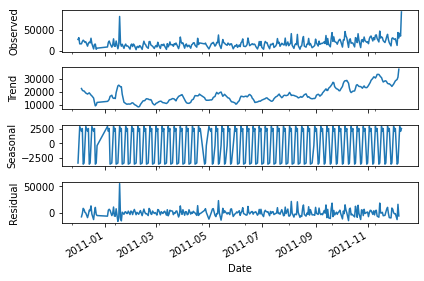

In [ ]:
#décomposition de la série temporelle
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_daily, freq=6)
res.plot()
plt.show()
#nous observons une tendance à la hausse : nous avons un modele multiplicatif et non additif

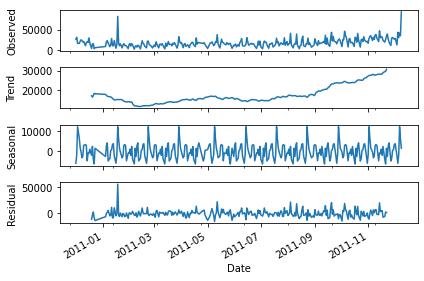

In [ ]:
#décomposition de la série temporelle avec freq = 30
res = seasonal_decompose(df_daily, freq=30)
res.plot()
plt.show()
#nous observons une tendance à la hausse : nous avons un modele multiplicatif et non additif

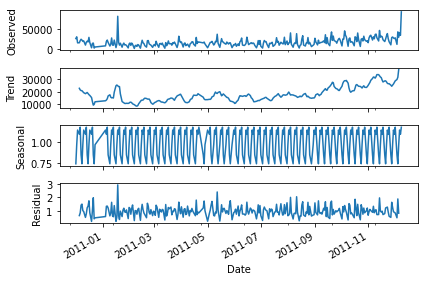

In [ ]:
#décomposition multiplicative de la série temporelle
res = seasonal_decompose(df_daily, model = 'multiplicative', freq=6)
res.plot()
plt.show()

In [ ]:
''' Commençons par utiliser la transormation en  log
  afin de nous ramener à un modèle additif '''

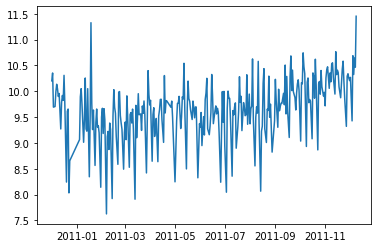

In [ ]:
df_dailylog = np.log(df_daily)
plt.plot(df_dailylog);

In [ ]:
'''La première étape d'une prévision à l'aide des modèles SARIMA est de stationnariser notre série temporelle, 
autrement dit, nous devons estimer les paramètres D et d de notre modèle SARIMA(p,d,q)(P,D,Q)s

On se sert des autocorrélatioons simples. Quel que soit le type de processus, si
 l'autocorrélation simple décroît assez rapidement vers 0 --> le processus est stationnaire.'''

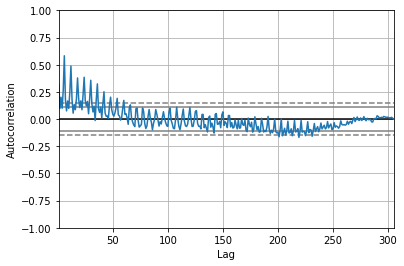

In [ ]:
pd.plotting.autocorrelation_plot(df_dailylog)

In [ ]:
''' La décroissance de la fonction d'autocorrélation est plutôt lente. 
On applique donc une différenciation d'ordre 1 sur notre série temporelle afin de voir si cela 
nous permet de la stationnariser. '''

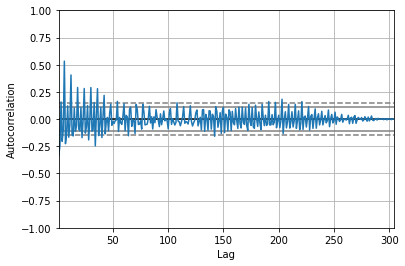

In [ ]:
df_dailylog_1 = df_dailylog.diff().dropna()
pd.plotting.autocorrelation_plot(df_dailylog_1)

In [ ]:
''' L'autocorrélation simple semble tendre vers 0 mais présente des pics saisonniers importants.
Il faut donc éliminer cette saisonnalité.
Nous avons supposé que la série temporelle comportait 
une saisonnalité de période 6 et cette hypothèse semble se confirmer au vu de la fréquence des pics. 
Nous appliquons donc une différenciation de valeur 6
'''

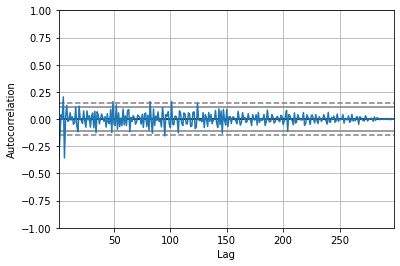

In [ ]:
df_dailylog_2 = df_dailylog_1.diff(periods = 6).dropna()
pd.plotting.autocorrelation_plot(df_dailylog_2);

In [ ]:
''' On arrive ici à un résultat assez satisfaisant malgré les quelques pics irréguliers,
 on peut dire que les valeurs décroissent suffisamment rapidement pour qu'on puisse considérer le processus 
 comme probablement stationnaire.
  On peut donc considérer que l'on a ici un estimateur de l'autocorrélogramme simple de notre processus 
Vérifions que la série est stationnaire '''

In [ ]:
# test de stationarité 
sm.tsa.stattools.adfuller(df_dailylog_2)

(-7.558451277872986,
 3.054932749042278e-11,
 14,
 283,
 {'1%': -3.453670163592738,
  '10%': -2.5722411158835796,
  '5%': -2.8718077069772248},
 379.9731878037207)

In [ ]:
''' on obtient une p-valeur très proche de 0 (donc < 5%) On peut rejeter l'hypothèse HO au seuil de 5%
--> Nous avons bien stationnarisé la série '''

In [ ]:
''' On a différencié une fois à l'ordre 1 et 1 fois à l'ordre 6 (car saisonalité de 6)
--> On a donc d=D=1
--> On a k=6 car saisonnalité de 6

Il nous reste à chercher les paramètres P,Q,p et q
  pour ainsi avoir un processus SARIMA qui pourrait modéliser au mieux notre série temporelle. 
  Pour cela, nous utiliserons les autocorrélogrammes simples et partiels '''

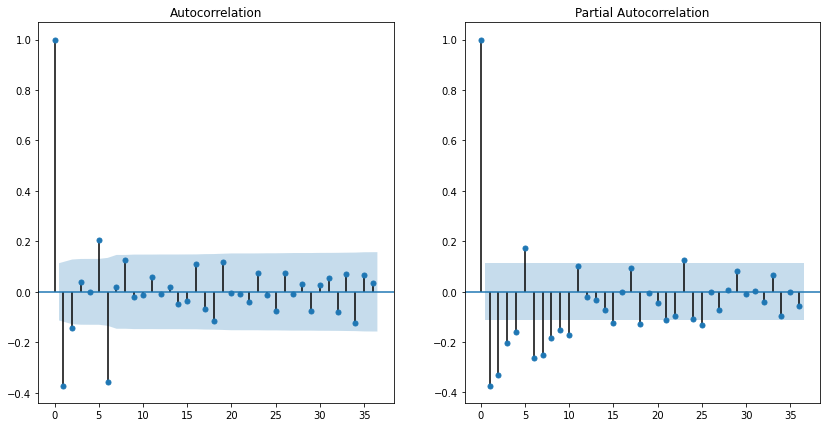

In [ ]:
plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(df_dailylog_2, lags = 36, ax=plt.gca())
plt.subplot(122)
plot_pacf(df_dailylog_2, lags = 36, ax=plt.gca())
plt.show()


In [ ]:
''' La zone bleutée représente la zone de non significativité des autocorrélogrammes. 
Les autocorrélogrammes simple et partiel s'annulent à partir du rang 2.
On a p=q=2-1=1 
Concernant la saisonalité, on distingue un petit pic pour chaque autocorrélogramme au rang 6,
puis rien de significatif aux rangs supérieurs. Les paramètres p,q,P et Q prendront donc tous initialement la valeur 1.
'''

## *2) Modèle ARIMA*

In [ ]:
# Représentation de la série temporelle
# 0 correspond au premier jour dans notre table, 1 au deuxième jour, etc...
fig = go.Figure(data=[go.Scatter(y=df_daily)])
fig.update_layout(xaxis_title="Date",yaxis_title="Volume de vente",title='Série temporelle',height=400,template='ggplot2')
fig.show()

In [ ]:
''' dans un premier temps, on fais un modèle ARIMA avec la transformation log

In [ ]:
# Train & Test Split 
series_date=df_dailylog
split_time = 250
time_d=np.arange(len(df_dailylog))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
# Daily: ARIMA Model
a_model = ARIMA(endog=train_d , order=(1, 1, 1))
a_model_fit=a_model.fit()
print(a_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  249
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -197.563
Method:                       css-mle   S.D. of innovations              0.533
Date:                Wed, 26 May 2021   AIC                            403.126
Time:                        13:43:30   BIC                            417.195
Sample:                             1   HQIC                           408.789
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0013      0.002      0.623      0.534      -0.003       0.005
ar.L1.D.Quantity     0.1321      0.068      1.936      0.054      -0.002       0.266
ma.L1.D.Quantity    -0.9505 

In [ ]:
#definition d'une fonction pour générer un graphique avec les données et leurs prédictions
def plot_(t_train,t_test,x_train,x_test,x_train_pred,x_test_pred,forecast,title):
    xt = (max(t_test)+np.arange(len(forecast)))+1
    fig_train=go.Scatter(name='Train : Actuel ',x=t_train,y=x_train,showlegend=True)
    fig_trian_pred=go.Scatter(name='Train : Prédiction',x=t_train,y=x_train_pred,showlegend=True)
    fig_test=go.Scatter(name='Test : Actuel',x=t_test,y=x_test,showlegend=True)
    fig_test_pred=go.Scatter(name='Test : Prédiction',x=t_test,y=x_test_pred,showlegend=True)
    fig_forecast=go.Scatter(name='Prévision',x=xt,y=forecast,showlegend=True)

    fig = go.Figure([fig_train,fig_trian_pred,fig_test,fig_test_pred,fig_forecast])
    fig.update_layout(xaxis_title='Date',yaxis_title="Volume de ventes",title=title 
                      ,height=400,hovermode="x",template='ggplot2')
    fig.show()

In [ ]:
#représentation des données avec leurs prédictions apportées par le modèle
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 9.55886550614974
MSE Test : nan


In [ ]:
''' Nous obtenons quelque chose d'étrange, le modèle ne prédit pas du tout correctement les données
cela est dû au paramètre d. nous devons le paramétrer à 0 '''

In [ ]:
a_model = ARIMA(endog=train_d , order=(1, 0, 1))
a_model_fit=a_model.fit()
print(a_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                  250
Model:                     ARMA(1, 1)   Log Likelihood                -195.675
Method:                       css-mle   S.D. of innovations              0.529
Date:                Wed, 26 May 2021   AIC                            399.351
Time:                        13:45:03   BIC                            413.436
Sample:                             0   HQIC                           405.020
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.5521      0.040    237.152      0.000       9.473       9.631
ar.L1.Quantity    -0.3110      0.130     -2.395      0.017      -0.565      -0.057
ma.L1.Quantity     0.5786      0.104

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
#représentation des données et de leurs prédictions 
# en gardant d'abord la transformation log
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes (en valeurs log) - Modèle ARIMA (transformation log)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 0.5293176497718692
MSE Test : nan


In [ ]:
''' Là, nous obtenons bien des prédictions plutôt correctes '''

In [ ]:
#représentation des données et de leurs prédictions 
# en prenant l'exponentiel pour revenir aux données initiales
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = np.exp(train_d),x_test = np.exp(test_d),
      x_train_pred = np.exp(train_pred)
      ,x_test_pred = np.exp(test_pred),forecast = forecast,title='Prévisions des ventes (valeurs initiales) - Modèle ARIMA (transformation log)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 0.5293176497718692
MSE Test : nan


In [ ]:
''' Pour terminer, il faut évaluer l'erreur effectuée par le modèle.
 Pour cela, on utilisera la métrique de Mean Average Prediction Error '''

test_d_true = np.array(np.exp(test_d))
test_pred_true = np.array(np.exp(test_pred))

MAPE = np.mean(np.abs((test_d_true - test_pred_true) / test_d_true)) * 100
print("Mean Average Prediction Error : %0.2f%%"% MAPE)

#on trouve un taux d'erreur de 49%

Mean Average Prediction Error : 49.03%


In [ ]:
''' Essayons maintenant un modèle ARIMA sans la transformation log'''

In [ ]:
# Train & Test Split 
series_date=df_daily
split_time = 250
time_d=np.arange(len(df_daily))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
#Modèle ARIMA
a_model = ARIMA(endog=train_d , order=(1, 0, 1))
a_model_fit=a_model.fit()
print(a_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                  250
Model:                     ARMA(1, 1)   Log Likelihood               -2617.490
Method:                       css-mle   S.D. of innovations           8526.095
Date:                Wed, 26 May 2021   AIC                           5242.979
Time:                        10:16:36   BIC                           5257.065
Sample:                             0   HQIC                          5248.648
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.613e+04    629.874     25.614      0.000    1.49e+04    1.74e+04
ar.L1.Quantity    -0.2866      0.184     -1.556      0.121      -0.648       0.074
ma.L1.Quantity     0.5035      0.162

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
#paramètre p non significatif --> on l'enlève
a_model = ARIMA(endog=train_d , order=(0, 0, 1))
a_model_fit=a_model.fit()
print(a_model_fit.summary())
#on se retrouve finalement avec un modèle MA

                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                  250
Model:                     ARMA(0, 1)   Log Likelihood               -2618.293
Method:                       css-mle   S.D. of innovations           8553.747
Date:                Wed, 26 May 2021   AIC                           5242.586
Time:                        13:47:50   BIC                           5253.150
Sample:                             0   HQIC                          5246.838
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.615e+04    664.729     24.297      0.000    1.48e+04    1.75e+04
ma.L1.Quantity     0.2296      0.068      3.385      0.001       0.097       0.363
                                    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
#représentation des données et de leurs prédictions 
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisons des ventes - Modèle ARIMA')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 8555.203647800967
MSE Test : nan


In [ ]:
''' Pour terminer, il faut évaluer l'erreur effectuée par le modèle.
 Pour cela, on utilisera la métrique de Mean Average Prediction Error '''

MAPE = np.mean(np.abs((np.array(test_d) - np.array(test_pred)) / np.array(test_d))) * 100
print("Mean Average Prediction Error : %0.2f%%"% MAPE)

# l'erreur de prédiction est de 44.17%
# On obtient une erreur plus faible 

Mean Average Prediction Error : 44.17%


## *3) Modèle SARIMA*

In [ ]:
 ''' On va maintenant faire un modèle SARIMA
 On a utilisé les séries df_dailylog_1 et df_dailylog_2 uniquement pour déterminer quel degré de différenciation 
 appliquer. On repart bien de notre série non différenciée df_dailylog pour appliquer le modèle SARIMA 
 qui se chargera de faire la différenciation. '''

In [ ]:
# On crée tout d'abord un modèle SARIMA sans spliter les données en échantillons train et test
model=sm.tsa.SARIMAX(df_dailylog,order=(1,1,1),seasonal_order=(1,1,1,6))
results=model.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  305
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -180.487
Date:                           Wed, 26 May 2021   AIC                            370.974
Time:                                   10:34:49   BIC                            389.459
Sample:                                        0   HQIC                           378.373
                                           - 305                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1800      0.069      2.618      0.009       0.045       0.315
ma.L1         -0.9669      0.022    -43.515

In [ ]:
''' nous avons uniquement des p-valeurs proches de 0, donc tous les paramètres sont tous significatifs 
Nous devons vérifier que le résidu est un bruit blanc et qu'il est distribué normalement.

Le test de Ljung-Box est un test de blancheur. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0
  : La résidu est un bruit blanc. Ici on lit sur la ligne Prob(Q) que la p-valeur de ce test est de 0.77
 , donc on ne rejette pas l'hypothèse.

Le test de Jarque-Bera est un test de normalité. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0
  : Le résidu suit une distribution normale. Ici on lit sur la ligne Prob (JB) que la p-valeur du test est de 0
 . On rejette donc l'hypothèse.
 donc les résidus ne vérifient pas l'hypothèse de normalité 
 --> le modèle sarima est-il pour autant satisfaisant ? 
 

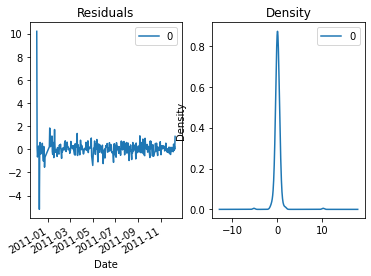

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#les résidus semblent tout de même suivre une distribution normale
#nous gardons notre modèle

In [ ]:
''' On va faire un modele en splitant les échantillons train et test

In [ ]:
# Daily: Train & Test Split
series_date=df_dailylog
split_time = 250
time_d=np.arange(len(df_dailylog))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
# Daily: SARIMAX Model

s_model = sm.tsa.SARIMAX(endog=train_d , order=(1, 1, 1), seasonal_order=(1, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -184.361
Date:                           Wed, 26 May 2021   AIC                            380.723
Time:                                   10:36:43   BIC                            401.681
Sample:                                        0   HQIC                           389.165
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -3.186e-07   4.06e-05     -0.008      0.994   -7.98e-05    7.92e-05
ar.L1          0.2510      0.135      1.863

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
''' le paramètre P n'est pas significatif (0.292 > 0.05)--> on le retire '''
s_model = sm.tsa.SARIMAX(endog=train_d , order=(1, 1, 1), seasonal_order=(0, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 6)   Log Likelihood                -181.768
Date:                           Sun, 09 May 2021   AIC                            373.537
Time:                                   14:02:50   BIC                            391.002
Sample:                                        0   HQIC                           380.572
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -8.122e-07   3.03e-05     -0.027      0.979   -6.02e-05    5.86e-05
ar.L1          0.2510      0.137      1.831

In [ ]:
''' le paramètre p n'est pas significatif (0.067 > 0.05) --> on le retire '''
s_model = sm.tsa.SARIMAX(endog=train_d , order=(0, 1, 1), seasonal_order=(0, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 6)   Log Likelihood                -188.584
Date:                           Wed, 26 May 2021   AIC                            385.168
Time:                                   13:48:59   BIC                            399.141
Sample:                                        0   HQIC                           390.796
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.639e-06   6.96e-05      0.052      0.958      -0.000       0.000
ma.L1         -0.5664      0.092     -6.171

In [ ]:
''' les paramètres sont significatifs mais les hypothèses sur les résidus ne sont pas vérifiées '''

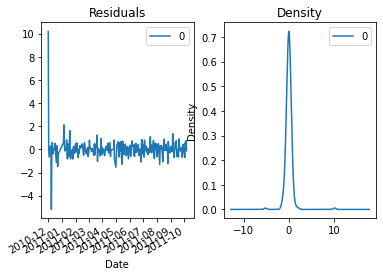

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(s_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#les résidus semblent tout de même suivre une distribution normale

In [ ]:
# représentation graphique des résultats grâce à la fonction plot_ crée plus tôt
# en gardant le logarithme des données
train_pred = s_model_fit.predict()
test_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

#fonction definie dans la partie 2) Modèle ARIMA
plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes (en valeurs log) - Modèle SARIMA (transforamtion log)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
# représentation graphique des résultats grâce à la fonction plot_ crée plus tôt
# en supprimant le logarithme des données (donc en prenant l'exponentiel) pour nous ramener aux données initiales

train_pred = s_model_fit.predict()
test_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = np.exp(train_d),x_test = np.exp(test_d),
      x_train_pred = np.exp(train_pred),x_test_pred = np.exp(test_pred),forecast = np.exp(forecast),
      title='Prévisions des ventes (valeurs initiales) - Modèle SARIMA (transformation log)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
''' Pour terminer, il faut évaluer l'erreur effectuée par le modèle.
 Pour cela, on utilisera la métrique de Mean Average Prediction Error '''

test_d_true = np.array(np.exp(test_d))
test_pred_true = np.array(np.exp(test_pred))

MAPE = np.mean(np.abs((test_d_true - test_pred_true) / test_d_true)) * 100
print("Mean Average Prediction Error : %0.2f%%"% MAPE)

''' l'erreur est abérrante, le modèle n'est pas utilisable '''

Mean Average Prediction Error : 172.63%


In [ ]:
''' Essayons de faire un modèle sans la transformation log

In [ ]:
# Daily: Train & Test Split
series_date=df_daily
split_time = 250
time_d=np.arange(len(df_daily))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
# Daily: SARIMAX Model
s_model = SARIMAX(endog=train_d , order=(1, 1, 1), seasonal_order=(1, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -2547.719
Date:                           Mon, 10 May 2021   AIC                           5107.438
Time:                                   12:49:19   BIC                           5128.396
Sample:                                        0   HQIC                          5115.880
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0207      0.031      0.668      0.504      -0.040       0.081
ar.L1          0.1877      0.109      1.723

In [ ]:
# on enlève le paramètre p car non significatif
s_model = SARIMAX(endog=train_d , order=(0, 1, 1), seasonal_order=(1, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -2550.816
Date:                           Wed, 26 May 2021   AIC                           5111.632
Time:                                   13:50:20   BIC                           5129.098
Sample:                                        0   HQIC                          5118.667
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0318      0.046      0.689      0.491      -0.059       0.122
ma.L1         -0.9542      0.060    -15.971

In [ ]:
''' les paramètres sont significatifs
l'hypothèse sur les bruits blancs est vérifiée mais la normalité n'est pas vérifiée

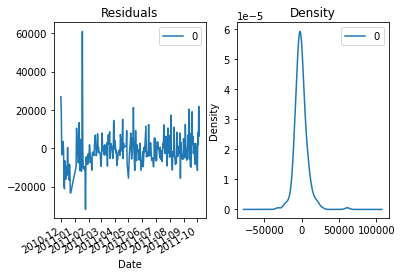

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(s_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#les résidus semblent tout de même suivre une distribution normale
#nous gardons notre modèle

In [ ]:
# représentation graphique des résultats grâce à la fonction plot_ crée plus tôt
train_pred = s_model_fit.predict()
test_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes - Modèle SARIMA')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
''' Pour terminer, il faut évaluer l'erreur effectuée par le modèle.
 Pour cela, on utilisera la métrique de Mean Average Prediction Error '''


MAPE = np.mean(np.abs((np.array(test_d) - np.array(test_pred)) / np.array(test_d))) * 100
print("Mean Average Prediction Error : %0.2f%%"% MAPE)

# l'erreur de prédiction est de 42.34%

Mean Average Prediction Error : 42.34%


In [ ]:
''' l'erreur de prédiction est 'plus correcte' qu'avec le modele en transformation log.
Peut-être que nous avions finalement un modèle additif ...

Nous pouvons garder ce modèle qui assure tout de même de bonnes prévisions '''

## *4) Modèle Auto-ARIMA*

In [ ]:
''' le but est de trouver les meilleurs paramètres à introduire dans le modèle, 
grâce à la fonction auto_arima du package pmdarima

In [ ]:
# Train & Test Split
series_date=df_daily
split_time = 250
time_d=np.arange(len(df_daily))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
pip install pmdarima as pm

     |████████████████████████████████| 1.5MB 5.1MB/s 
     |████████████████████████████████| 9.5MB 22.9MB/s 
  Created wheel for pm: filename=pm-0.1.1-cp37-none-any.whl size=9285 sha256=376588781d0261f9f8920eae4d88849958a0b9f49171313378eb4448ca04bcb1
  Stored in directory: /root/.cache/pip/wheels/55/e0/0c/7a6356cd6097c4670c6ad74ffcd9b5af47045b73f49917b4df
Successfully built pm
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
#ce code nous permet de trouver des paramètres optimaux pour un modèle ARIMA
# autrement dit, celui qui minimise la métrique AIC
model = auto_arima(train_d, start_p=1, start_q=1,
                      test='adf',       # pour chercher le 'd' optimal
                      max_p=3, max_q=3, # les valeurs maximales testées pour p et q
                      m=1,              # frequence series
                      d=None,           # laisser le modèle determiner 'd'
                      seasonal=False,   # Pas de saisonnalité
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5245.046, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5620.175, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5348.770, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5503.509, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5245.200, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5244.559, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5487.663, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5247.565, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5242.758, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5469.189, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5246.723, Time=0.13 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 2.095 seconds
                           Statespace Model Results                           
Dep. Variable:

In [ ]:
''' --> le meilleur modèle est ARIMA(1,0,3) 
Nous allons représenter les prédictions et calculer le mAPE
'''

In [ ]:
a_model = ARIMA(endog=train_d , order=(1, 0, 3))
a_model_fit=a_model.fit()
print(a_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                  250
Model:                     ARMA(1, 3)   Log Likelihood               -2611.686
Method:                       css-mle   S.D. of innovations           8320.112
Date:                Wed, 26 May 2021   AIC                           5235.373
Time:                        13:51:01   BIC                           5256.501
Sample:                             0   HQIC                          5243.876
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.757e+04   2398.469      7.325      0.000    1.29e+04    2.23e+04
ar.L1.Quantity     0.9806      0.022     44.530      0.000       0.937       1.024
ma.L1.Quantity    -0.8255      0.067

In [ ]:
#représentation des données avec leurs prédictions apportées par le modèle
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes - Modèle ARIMA (paramètres optimaux)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 8328.155546665233
MSE Test : nan


In [ ]:
''' calcul de Mean Average Prediction Error '''

MAPE = np.mean(np.abs((np.array(test_d) - np.array(test_pred)) / np.array(test_d))) * 100
print("Mean Absolute Prediction Error : %0.2f%%"% MAPE)

# l'erreur de prédiction est de 38.21%
#on a trouvé un modèle ARIMA avec une erreur de prédiction plus faible

Mean Absolute Prediction Error : 38.21%


## *5) Modèle Auto-SARIMA*

In [ ]:
''' Le but est de rechercher les meilleurs paramètres pour un modèle SARIMA 
pour ainsi obtenir une erreur de prédiction plus faible '''

In [ ]:
# Train & Test Split
series_date=df_daily
split_time = 250
time_d=np.arange(len(df_daily))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
#on utilise la même fonction que précedemment, qui nous permet d'obtenir les meilleurs paramètres 
#pour un modèle SARIMA
#autrement dit, ceux pour lesquels le AIC est minimisé
smodel = auto_arima(train_d, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=6,
                         start_P=0, seasonal=True, #on prend en compte la saisonnalité
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[6] intercept   : AIC=5102.124, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : AIC=5158.126, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : AIC=5127.505, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[6] intercept   : AIC=5100.618, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[6]             : AIC=5156.230, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[6] intercept   : AIC=5155.892, Time=0.06 sec
 ARIMA(0,0,1)(1,1,1)[6] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,0,1)(0,1,2)[6] intercept   : AIC=5093.576, Time=0.53 sec
 ARIMA(0,0,1)(1,1,2)[6] intercept   : AIC=5093.676, Time=0.92 sec
 ARIMA(0,0,0)(0,1,2)[6] intercept   : AIC=5096.428, Time=0.40 sec
 ARIMA(1,0,1)(0,1,2)[6] intercept   : AIC=5095.290, Time=0.78 sec
 ARIMA(0,0,2)(0,1,2)[6] intercept   : AIC=5095.319, Time=0.66 sec
 ARIMA(1,0,0)(0,1,2)[6] intercept   : AIC=5093.903, Time=0.56 sec
 ARIMA(1,0,2)(0,1,2)[6] intercept   : AIC=5097.307, Time=1.22 sec
 ARIMA(0,0,1)(0,1,2)[6]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  250
Model:             SARIMAX(0, 0, 1)x(0, 1, 2, 6)   Log Likelihood               -2541.788
Date:                           Mon, 10 May 2021   AIC                           5093.576
Time:                                   13:51:11   BIC                           5111.061
Sample:                                        0   HQIC                          5100.618
                                           - 250                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    132.6839    161.736      0.820      0.412    -184.313     449.681
ma.L1          0.1502      0.127      1.182      0.237      -0.099       0.399
ma.S.L6       -0.6472      0.059    -10.885      0.000      -0.764      -0.531
ma.S.L12      -0.2149      0.054     -3.970      0.000      -0.321      -0.109
sigma2      8.626e+07      0.002   5.29e+10      0.000    8.63e+07    8.63e+07
===================================================================================
Ljung-Box (Q):                       17.60   Jarque-Bera (JB):              2691.46
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             2.35
Prob(H) (two-sided):                  0.12   Kurtosis:                        18.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.99e+25. Standard errors may be unstable.
"""

In [ ]:
''' Le meilleur modèle est SARIMAX(0, 0, 1)x(0, 1, 2, 6)
Etudions ce modèle
'''

In [ ]:
s_model = sm.tsa.SARIMAX(endog=train_d , order=(0, 0, 1), seasonal_order=(0, 1, 2, 6), trend='t')
s_model_fit=s_model.fit()


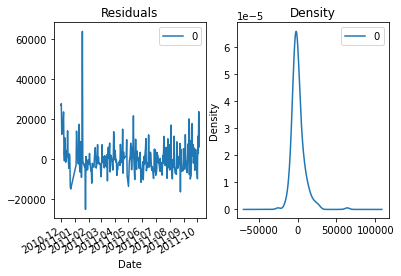

In [ ]:
''' Là encore, l'hypothèse sur les bruits blancs est vérifiée mais pas celle sur la normalité '''
# Plot residual errors
residuals = pd.DataFrame(s_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#les résidus semblent tout de même suivre une distribution normale
#nous gardons notre modèle

In [ ]:
#représentation des données avec leurs prédictions apportées par le modèle
train_pred = s_model_fit.predict()
test_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes - Modèle SARIMA (paramètres optimaux)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 8450.84121104134
MSE Test : nan


In [ ]:
''' calcul de Mean Average Prediction Error '''

MAPE = np.mean(np.abs((np.array(test_d) - np.array(test_pred)) / np.array(test_d))) * 100
print("Mean Absolute Prediction Error : %0.2f%%"% MAPE)

# l'erreur de prédiction est de 29.34%, ce qui est plutôt correct
#on a trouvé un meilleur modèle SARIMA avec une plus faible erreur de prédiction
# C'est le modèle que nous retenons à présent.

Mean Absolute Prediction Error : 29.34%


# **Conclusion**

Après avoir testé plusieurs modèles de régression non satisfaisants, nous obtenons au final d'assez bons modèles de prédictions en utilisant les algorithmes ARIMA et SARIMA.

Notre étude nous a permis d'obtenir un modèle de prévision de vente adapté à nos données et donnant ainsi une erreur de prédiction assez faible de 29%. 
Cette erreur de prédiction aurait pu être améliorée si nous avions un historique plus large dans notre jeu de données (au moins 2 ans). En effet, il existe une saisonnalité d'une année à l'autre, et cela nous aurait permis d'avoir un modèle plus performant.